In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

from prepare_images import prep_image
from vgg16 import build_model
from trainer import train

Using gpu device 0: GeForce GT 640M (CNMeM is disabled, cuDNN not available)


In [2]:
pre_trained_model = pickle.load(open('vgg16.pkl'))
net = build_model()
lasagne.layers.set_all_param_values(net['prob'], pre_trained_model['param values'])
IMAGE_MEAN = pre_trained_model['mean value'][:, np.newaxis, np.newaxis]

In [3]:
X = []
y = []

for cls in xrange(10):
    for fn in os.listdir('./leedsbutterfly/classes/{}'.format(cls+1)):
        _, im = prep_image('./leedsbutterfly/classes/{}/{}'.format(cls+1, fn), IMAGE_MEAN=IMAGE_MEAN)
        X.append(im)
        y.append(cls)
        
X = np.concatenate(X)
y = np.array(y).astype('int32')
print X.shape
print y.shape

(832, 3, 224, 224)
(832,)


In [5]:
# Split data into training, testing and validation set
rng = np.random.RandomState(0)
permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
train_idxs, test_idxs = train_test_split(range(len(y)),  random_state=0)
train_idxs, val_idxs = train_test_split(range(len(train_idxs)),  random_state=0)

X_train = X[train_idxs]
y_train = y[train_idxs]

X_val = X[val_idxs]
y_val = y[val_idxs]

X_test = X[test_idxs]
y_test = y[test_idxs]

print X_train.shape, y_train.shape
print X_val.shape, y_val.shape
print X_test.shape, y_test.shape
# check training data contains examples from all classes in good number
print sum(y_train==0)
print sum(y_train==1)
print sum(y_train==2)
print sum(y_train==3)
print sum(y_train==4)
print sum(y_train==5)
print sum(y_train==6)
print sum(y_train==7)
print sum(y_train==8)
print sum(y_train==9)

(468, 3, 224, 224) (468,)
(156, 3, 224, 224) (156,)
(208, 3, 224, 224) (208,)
41
54
35
52
51
50
52
39
44
50


In [6]:
# connect output classifier to the last fully connected layer of the network
net['scores'] = lasagne.layers.DenseLayer(net['fc7_dropout'], num_units=10, 
                                          nonlinearity=lasagne.nonlinearities.softmax)

In [7]:
model, loss_history, train_acc_history, val_acc_history, predict_fn = train(net, X_train, y_train, X_val, y_val,
                                                                            batch_size=10, num_epochs=20)

training
epoch 1 / 20 : training loss: 3.349055, training accuracy: 0.613, validation loss: 2.347239, validation accuracy: 0.813
epoch 2 / 20 : training loss: 2.259265, training accuracy: 0.902, validation loss: 2.279226, validation accuracy: 0.873
epoch 3 / 20 : training loss: 2.587230, training accuracy: 0.837, validation loss: 2.262892, validation accuracy: 0.913
epoch 4 / 20 : training loss: 2.344350, training accuracy: 0.902, validation loss: 2.163625, validation accuracy: 0.940
epoch 5 / 20 : training loss: 2.141432, training accuracy: 0.935, validation loss: 2.316642, validation accuracy: 0.907
epoch 6 / 20 : training loss: 2.283001, training accuracy: 0.935, validation loss: 2.490699, validation accuracy: 0.860
epoch 7 / 20 : training loss: 2.006032, training accuracy: 0.965, validation loss: 2.340105, validation accuracy: 0.920
epoch 8 / 20 : training loss: 1.934502, training accuracy: 0.987, validation loss: 1.925724, validation accuracy: 0.980
epoch 9 / 20 : training loss: 1

In [8]:
#save the model and solver for later use
with open('saved_model1.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

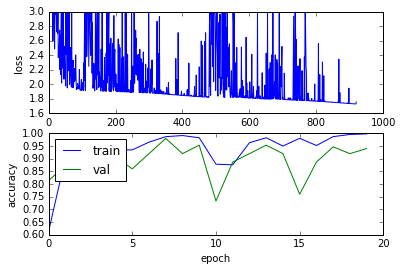

In [9]:
plt.subplot(2, 1, 1)
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [10]:
print "best validation accuracy after training for 20 epochs: ",  max(val_acc_history)

best validation accuracy after training for 20 epochs:  0.98


In [11]:
species = {0:'Danaus plexippus', 1:'Heliconius charitonius', 2:'Heliconius erato', 3:'Junonia coenia', 
          4:'Lycaena phlaeas', 5:'Nymphalis antiopa', 6:'Papilio cresphontes', 7:'Pieris rapae', 
          8:'Vanessa atalanta', 9:'Vanessa cardui'}

In [12]:
def classify(img_name, predict_fn, species):
    X_unseen = []
    rawim, im = prep_image(img_name)
    plt.imshow(rawim)
    X_unseen.append(im)
    X_unseen = np.concatenate(X_unseen)
    y_pred = int(''.join(map(str, predict_fn(X_unseen))))
    return y_pred

its Danaus plexippus


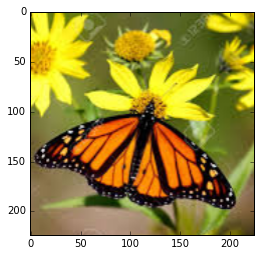

In [15]:
y_pred = classify('unseen_danus_plexipus.jpg', predict_fn, species)
print "its %s" %(species[y_pred])

its Vanessa cardui


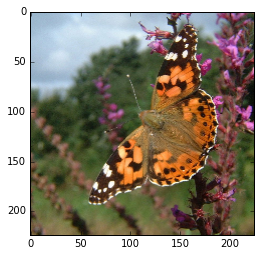

In [16]:
y_pred = classify('unseenvanessacardui.jpg', predict_fn, species)
print "its %s" %(species[y_pred])

In [17]:
y_test_pred = predict_fn(X_test)

In [18]:
print np.mean(y_test==y_test_pred)

0.966346153846


In [19]:
print confusion_matrix(y_test, y_test_pred)

[[20  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  1  1]
 [ 0  0  0 24  0  0  0  0  0  1]
 [ 0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  1  0  0  0  0  0 19  0  0]
 [ 0  0  1  0  0  0  0  0 22  0]
 [ 0  0  0  0  2  0  0  0  0 20]]
